<a href="https://www.kaggle.com/code/lucasfuller96/hyperparameter-tuning-with-optuna?scriptVersionId=171942768" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/spaceship-titanic/sample_submission.csv
/kaggle/input/spaceship-titanic/train.csv
/kaggle/input/spaceship-titanic/test.csv


# Import Libraries 

In [2]:
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.model_selection import train_test_split, KFold
from sklearn.metrics import classification_report, accuracy_score, log_loss
from sklearn.ensemble import RandomForestClassifier

import seaborn as sns
sns.set_theme()

import optuna
from optuna.samplers import TPESampler
from optuna.exceptions import ExperimentalWarning

import warnings
warnings.filterwarnings("ignore", category=ExperimentalWarning)

# Import Datasets

In [3]:
train = pd.read_csv('/kaggle/input/spaceship-titanic/train.csv')
test = pd.read_csv('/kaggle/input/spaceship-titanic/test.csv')

# Lets take a look at the dataset!

From the Kaggle docs:
- PassengerId - A unique Id for each passenger. Each Id takes the form gggg_pp where gggg indicates a group the passenger is travelling with and pp is their number within the group. People in a group are often family members, but not always.
- HomePlanet - The planet the passenger departed from, typically their planet of permanent residence.
- CryoSleep - Indicates whether the passenger elected to be put into suspended animation for the duration of the voyage. Passengers in cryosleep are confined to their cabins.
- Cabin - The cabin number where the passenger is staying. Takes the form deck/num/side, where side can be either P for Port or S for Starboard.
- Destination - The planet the passenger will be debarking to.
- Age - The age of the passenger.
- VIP - Whether the passenger has paid for special VIP service during the voyage.
- RoomService, FoodCourt, ShoppingMall, Spa, VRDeck - Amount the passenger has billed at each of the Spaceship Titanic's many luxury amenities.
- Name - The first and last names of the passenger.
- Transported - Whether the passenger was transported to another dimension. This is the target, the column you are trying to predict.

In [4]:
train.head()

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported
0,0001_01,Europa,False,B/0/P,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0,Maham Ofracculy,False
1,0002_01,Earth,False,F/0/S,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,44.0,Juanna Vines,True
2,0003_01,Europa,False,A/0/S,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,6715.0,49.0,Altark Susent,False
3,0003_02,Europa,False,A/0/S,TRAPPIST-1e,33.0,False,0.0,1283.0,371.0,3329.0,193.0,Solam Susent,False
4,0004_01,Earth,False,F/1/S,TRAPPIST-1e,16.0,False,303.0,70.0,151.0,565.0,2.0,Willy Santantines,True


In [5]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8693 entries, 0 to 8692
Data columns (total 14 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   PassengerId   8693 non-null   object 
 1   HomePlanet    8492 non-null   object 
 2   CryoSleep     8476 non-null   object 
 3   Cabin         8494 non-null   object 
 4   Destination   8511 non-null   object 
 5   Age           8514 non-null   float64
 6   VIP           8490 non-null   object 
 7   RoomService   8512 non-null   float64
 8   FoodCourt     8510 non-null   float64
 9   ShoppingMall  8485 non-null   float64
 10  Spa           8510 non-null   float64
 11  VRDeck        8505 non-null   float64
 12  Name          8493 non-null   object 
 13  Transported   8693 non-null   bool   
dtypes: bool(1), float64(6), object(7)
memory usage: 891.5+ KB


We will create a combined dataset so that we can make any preprocessing to both dataset at once.

In [6]:
train_len = train.shape[0]
test_len = test.shape[0]

test['Transported'] = False

train_test = pd.concat([train,test], axis = 0)

Having a quick look at the histograms of the spending features, we've got a large skew caused by a disproportionate number of 0 values, and large valued outliers. Since we're using Random Forest, we don't need to transform these numerical features, since Random Forest handles outliers and skewed distributions well, although it can help with visualisations so we will in this case. If we were using a non-tree based model (e.g. Logistic Regression), we would want to log transform the skewed features and add a maximum value to cap large outliers because this can aid in model learning.

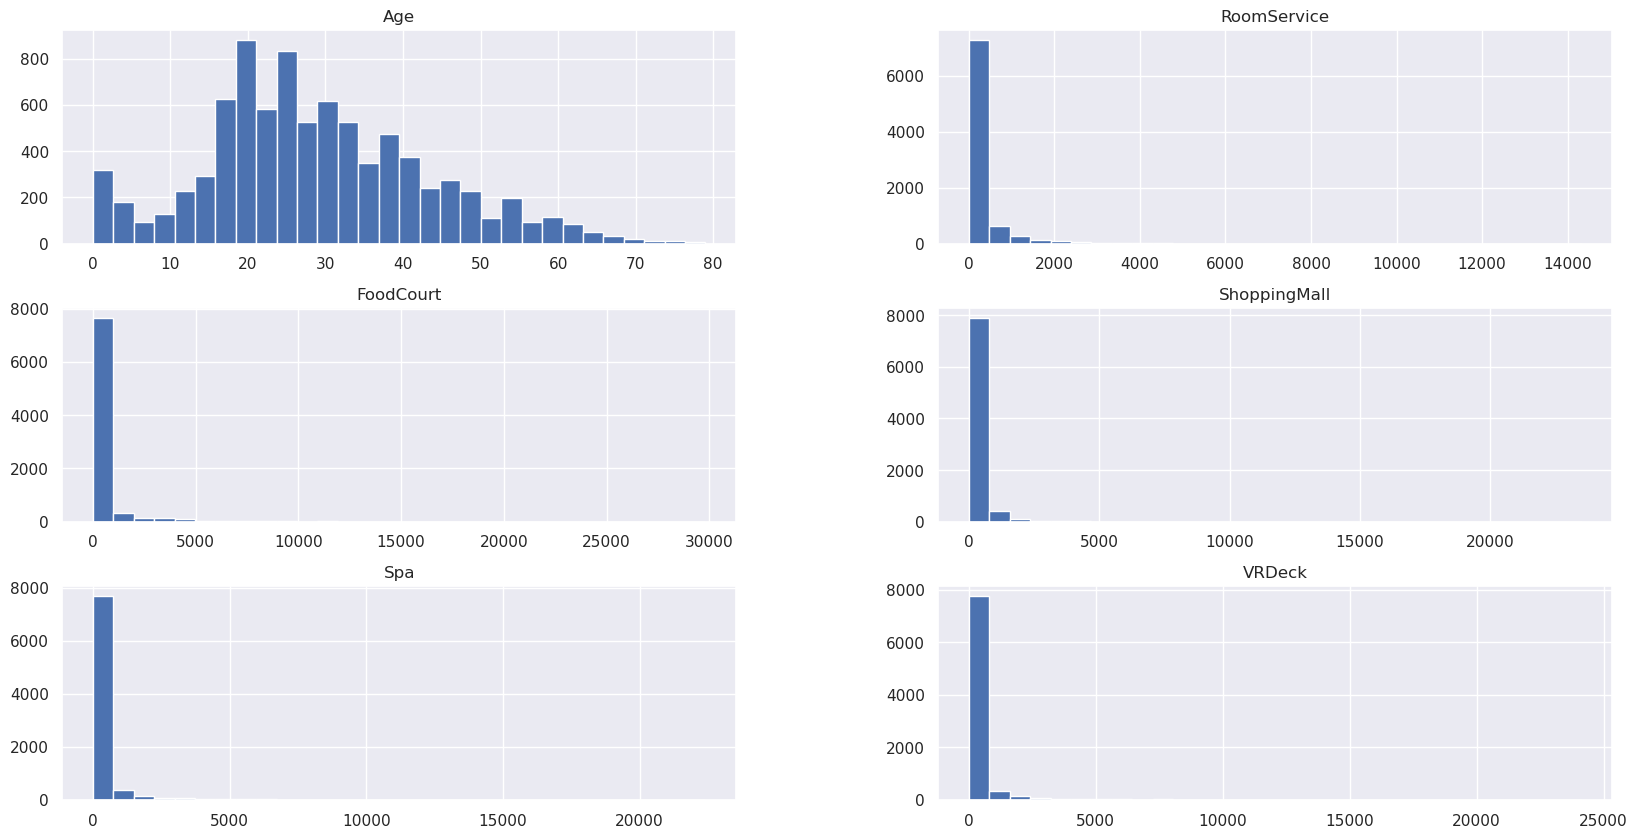

In [7]:
train.hist(bins = 30, figsize=(20,10))
plt.show()

Here we've created a function to help us visualise the correlation between a feature and the target variable.

In [8]:
def feature_to_target(dataset, columns, figsize=(20,10), bins=50, remove_0_values=False):
    
    plt.figure(figsize=figsize)
    
    for n, column in enumerate(columns):
        
        length = int(np.round(len(columns) ** 0.5))
        
        plt.subplot(length, length+1,n+1)
    
        if remove_0_values == True:
            
            mask = dataset[column] > 0
            sns.histplot(dataset[mask],x=column, hue="Transported", multiple="stack", bins=bins)
        
        else:
            
            sns.histplot(dataset,x=column, hue="Transported", multiple="stack", bins=bins)
        
        
    plt.show()

## Age

The Age distribution looks to have distinct age bandings, so we will be splitting this into a categorical feature for discrete age bandings.

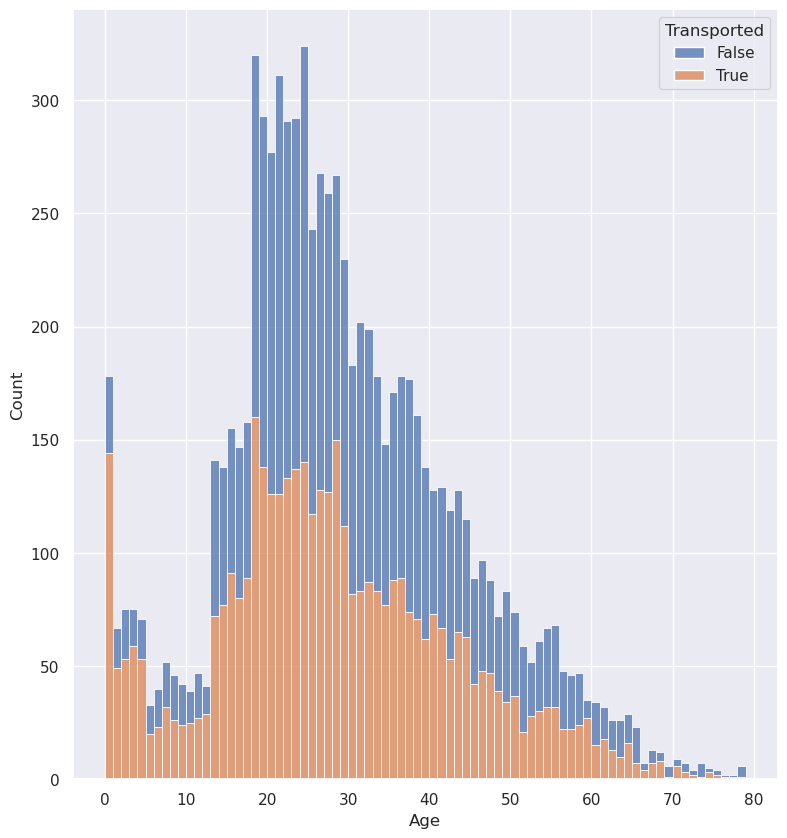

In [9]:
age_bins = int(train_test['Age'].max() - train_test['Age'].min())

feature_to_target(train_test[0:train_len], ['Age'], figsize=(20,10), bins=age_bins)

In [10]:
# fill na's with mean age from training set
train_test["Age"] = train_test["Age"].fillna(train_test.iloc[0:train_len]["Age"].mean())

#Then create new variable that groups Age into groups
bins = [-1, 4, 12, 17, 24, 29, 39, 49, 59, 69, 79]
names = ['0-4', '5-12', '13-17', '18-24', '25-29', '30-39', '40-49', '50-59', '60-69', '70-79']

train_test['AgeBand'] = pd.cut(train_test['Age'], bins, labels=names)

train_test.drop('Age', axis=1, inplace=True)

Passengers younger than 18 have a higher chance of being transported, with the 0-4 range having the higher proportion of transported passengers. Those in 18-24 and 30-39 are more likely to not be transported, with the rest having fairly even splits.

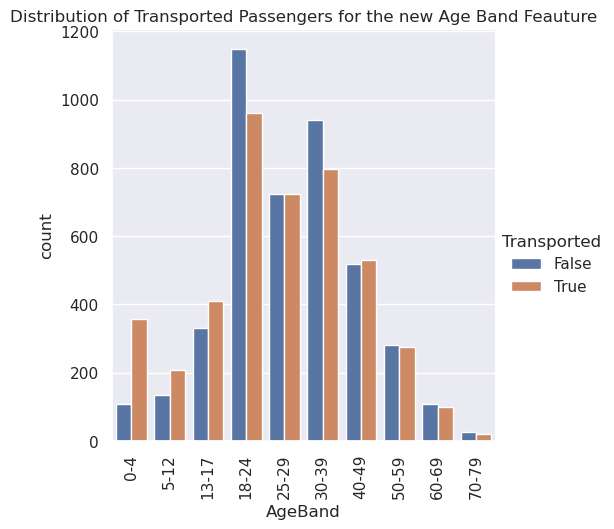

In [11]:
sns.catplot(data=train_test[0:train_len], x="AgeBand", kind="count", hue='Transported')

plt.xticks(rotation=90)
plt.title('Distribution of Transported Passengers for the new Age Band Feauture')

plt.show()

## Spending Features

Going back to the spending features, we will be capping the shopping columns at 3 standard deviations above the mean. First, we will impute the na values with 0, on the assumption that missing spending data means that no money was spent.

*Note: This would need to be investigated further if assumption was incorrect (we could estimate the spendings based on other variables, e.g. age).*


In [12]:
train_test["RoomService"] = train_test["RoomService"].fillna(0)
train_test["Spa"] = train_test["Spa"].fillna(0)
train_test["VRDeck"] = train_test["VRDeck"].fillna(0)
train_test["FoodCourt"] = train_test["FoodCourt"].fillna(0)
train_test["ShoppingMall"] = train_test["ShoppingMall"].fillna(0)

In [13]:
shopping_columns = ['RoomService','Spa','VRDeck','FoodCourt','ShoppingMall']

avg = train.loc[:,shopping_columns].mean()      
std = train.loc[:,shopping_columns].std(0)

clip = list(avg + 3 * std)

train_test.loc[:,shopping_columns] = train_test.loc[:,shopping_columns].clip(upper=clip, axis=1)

Looking at how each shopping column is correlated with the target variable (with the 0 values removed), there are some differences between the distributions of Transported passengers so we will keep them separate but could experiment with combining them. 
- Spa and VRDeck have fairly similar distributions, especially in their lower and maximum spending bins
- FoodCourt and ShoppingMall are also fairly similar in how their maximum spend bins are distributed, but across the lower spending bins they are less similar


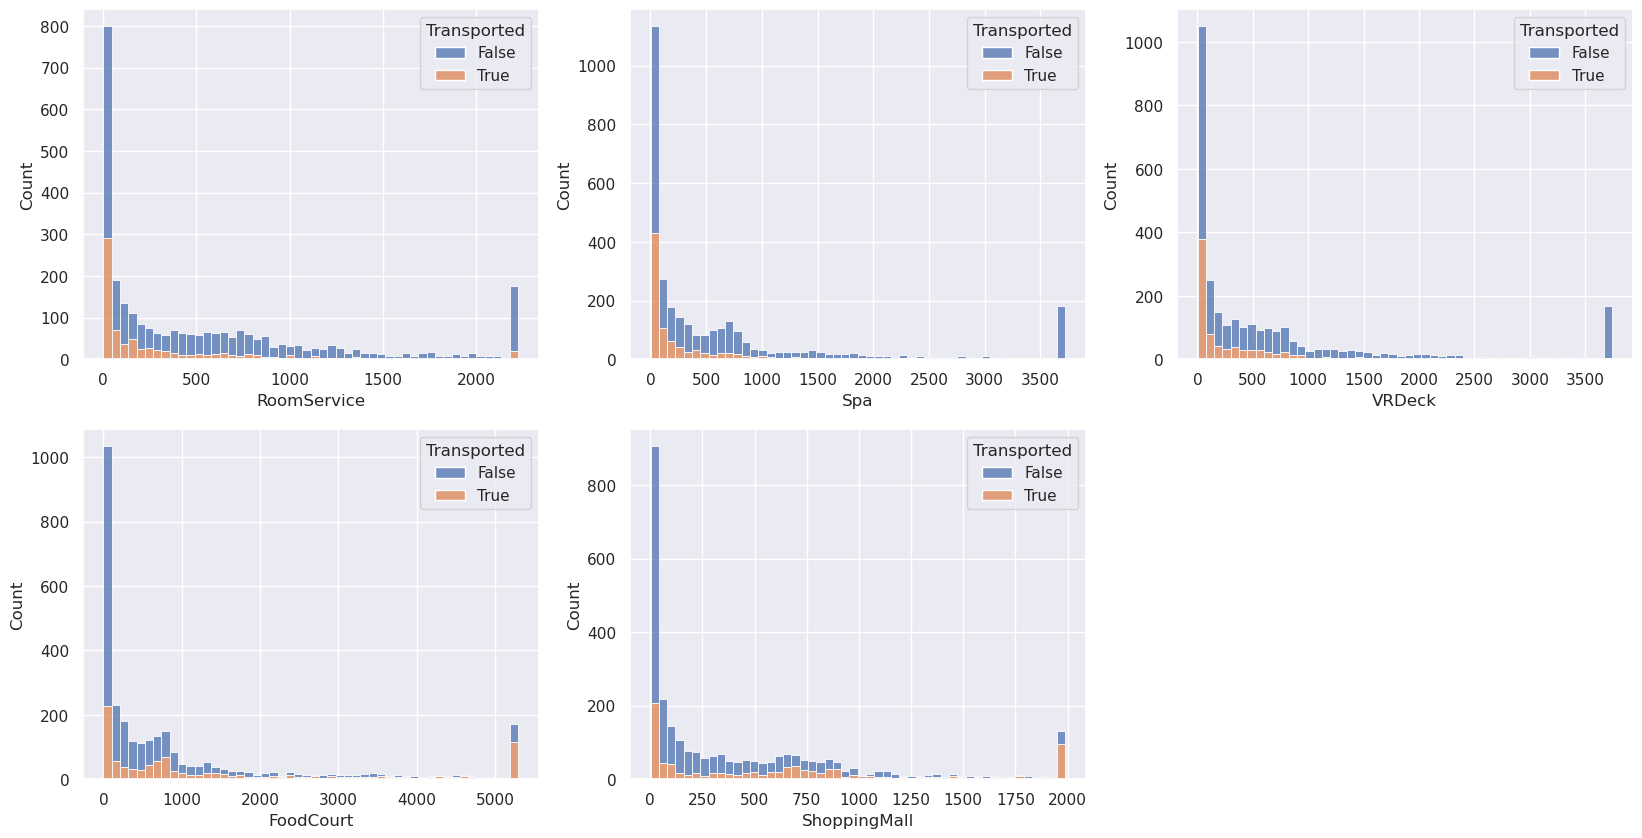

In [14]:
feature_to_target(train_test[0:train_len], shopping_columns, figsize=(20,10), bins=50, remove_0_values=True)

Whether the passenger spent $0 or the maximum capped value may be useful binary features to add, we'll add them and we can test their usefulness later.

In [15]:
train_test['RoomService_0'] = train_test['RoomService'] == 0
train_test['RoomService_Max'] = train_test['RoomService'] == clip[0]

train_test['Spa_0'] = train_test['Spa'] == 0
train_test['Spa_Max'] = train_test['Spa'] == clip[1]

train_test['VRDeck_0'] = train_test['VRDeck'] == 0
train_test['VRDeck_Max'] = train_test['VRDeck'] == clip[2]

train_test['FoodCourt_0'] = train_test['FoodCourt'] == 0
train_test['FoodCourt_Max'] = train_test['FoodCourt'] == clip[3]

train_test['ShoppingMall_0'] = train_test['ShoppingMall'] == 0
train_test['ShoppingMall_Max'] = train_test['ShoppingMall'] == clip[4]

## PassengerID and Cabin

PassengerId is a combination of the feature Group and GroupID so we will split that. Similarly, Cabin is a combination of Deck, Num and Side so we will also split those into features to see what is useful.

In [16]:
# split PassengerId into Group and GroupID
train_test["Group"] = train_test ['PassengerId'].str[0:4].astype('int')
train_test["GroupID"] = train_test ['PassengerId'].str[-2:].astype('int')

# set PassengerID as index
train_test.set_index("PassengerId", inplace = True)

# Split Cabin into Deck/Num/Side ()
train_test[['Deck','Num','Side']] = train_test['Cabin'].str.split('/', expand = True)

train_test['Num'] = train_test['Num'].astype(float)

# drop original Cabin features and age for now
train_test = train_test.drop('Cabin', axis = 1)
train_test = train_test.drop('Name', axis = 1)

## Categorica Features

Looking at the categorical features:
- The different Homeplanets correlate differently to Transported, with Europa being mostly Transported passengers, Earth being mostly not Transported, and Mars being a fairly even split.
- CyroSleep looks to be a useful feature with those who were in Cryosleep being very likely to be Transported
- Destination seems to be not as useful as other features, with there being a fairly even split for TRAPPISE-1e and PSO J318.5-22. 55 Cancri e is the only one where there is a lean more towards Transported.
- VIP doesn't seem to give us a lot of information
- Deck and Side are both decent indicators of whether a customer will be Transported so should make useful features
- GroupID looks to lean more towards Transported as the GroupID increases


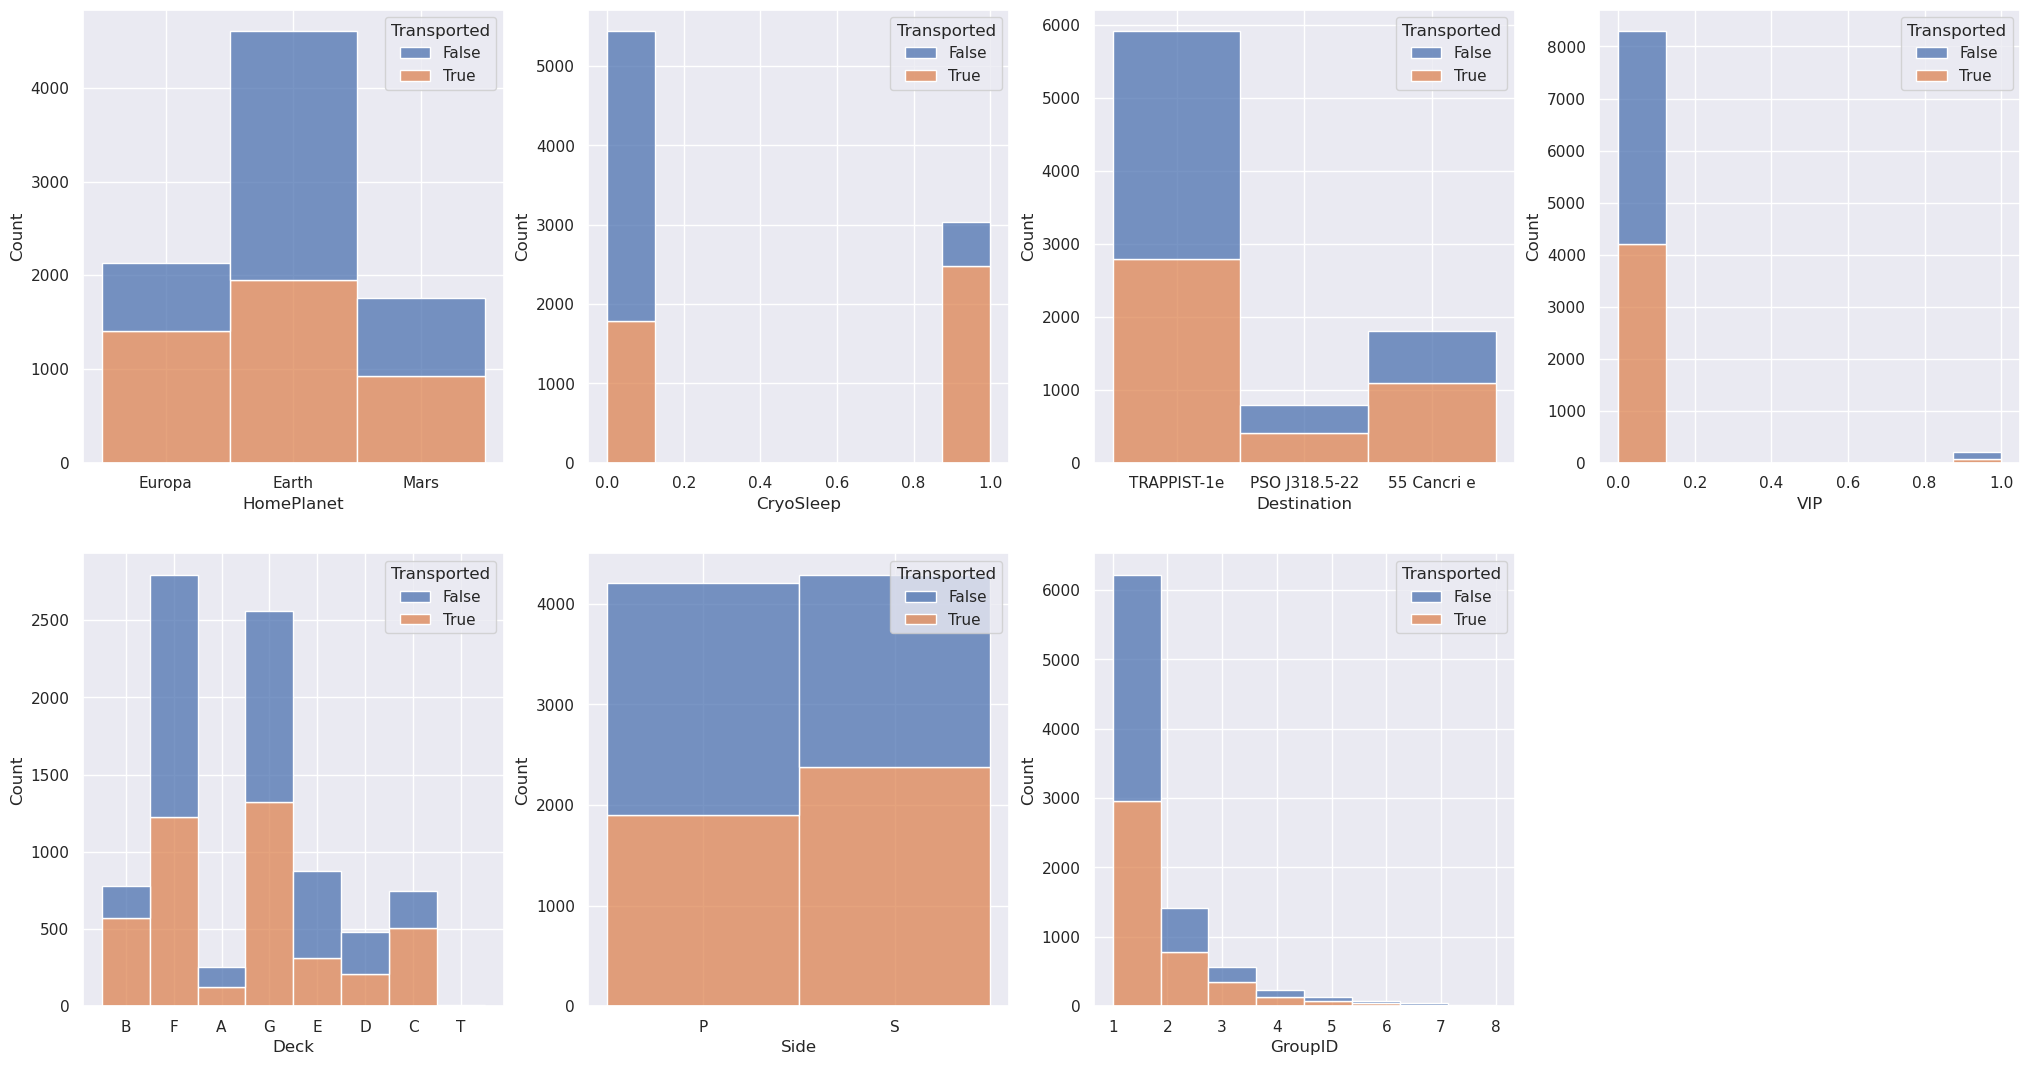

In [17]:
catogorical_columns = ['HomePlanet','CryoSleep','Destination','VIP','Deck','Side', 'GroupID']

feature_to_target(train_test[0:train_len], catogorical_columns, figsize=(25,20), bins=8)

The new features Group and Num both have a large range of values. The Transported split for the Group bands is pretty much 50/50 for all of the bands, so doesn't look like it will be a useful feature. We may be able to use it to help us impute other columns though, so we'll keep it for now. Num does look to be more useful and we can split it into groupings like we did for age, but we need to impute the na values first.

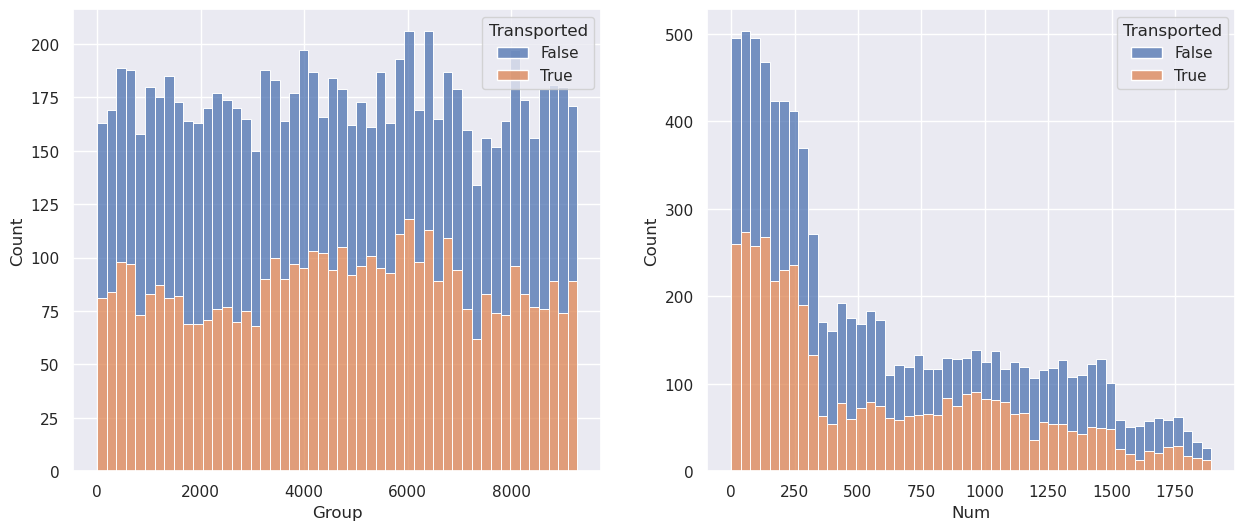

In [18]:
group_num_columns = ['Group','Num']

feature_to_target(train_test[0:train_len], group_num_columns, figsize=(15,6), bins=50)

## Group vs Num

If we plot Group against Num we can see there is a fairly linear trend for each of the Deck and Side combinations. From this we should be able to impute na values for Num based on linear models for each Deck/Side combination. Before we do that let's impute na values for Deck and Side so we can predict all values.

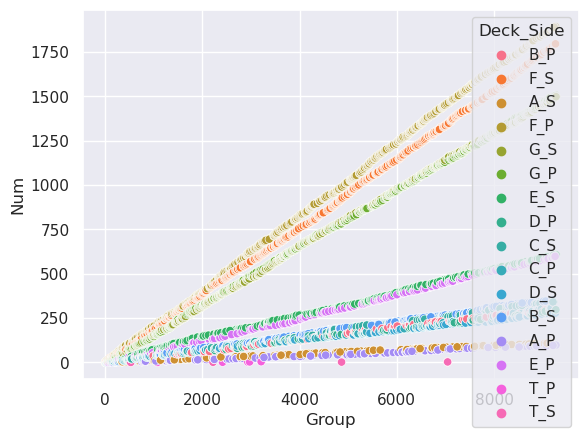

In [19]:
train_test['Deck_Side'] = train_test['Deck'] + '_' + train_test['Side']

sns.scatterplot(train_test, x='Group', y='Num', hue='Deck_Side')

plt.show()

## Imputing Values

It looks like Groups almost always stay on the same Deck, with only a small proportion being across 2 and an even smaller proportion across 3, so we can use group to infer deck when possible. We may be able to do the same mapping exercise in other places so we'll create a function that will do this for us.

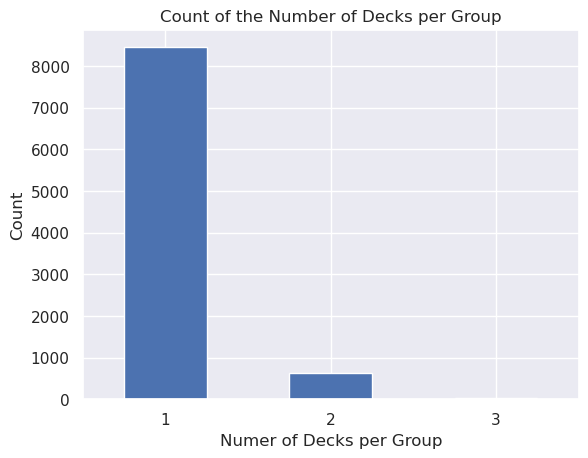

In [20]:
decks_per_group = (pd.crosstab(train_test['Group'], train_test['Deck']) > 0).sum(axis=1).value_counts()

decks_per_group.plot(kind='bar')

plt.xlabel('Numer of Decks per Group')
plt.xticks(rotation=0)
plt.ylabel('Count')

plt.title('Count of the Number of Decks per Group')

plt.show()

In [21]:
def impute_from_mapping(df, impute_column, mapping_column, mapping):
    
    column_na = df[impute_column].isna()
    column_na_before = column_na.sum()
    
    df.loc[column_na, impute_column] = df.loc[column_na, mapping_column].map(mapping)
    
    column_na_after = df[impute_column].isna().sum()
    
    print(f'The Nan values for {impute_column} were reduced from {column_na_before} to {column_na_after}')
    
    return df

In [22]:
deck_group_ct = pd.crosstab(train_test['Group'], train_test['Deck'])

deck_group_mapping = deck_group_ct.idxmax(axis=1).to_dict()

train_test = impute_from_mapping(train_test, 'Deck', 'Group', deck_group_mapping)

The Nan values for Deck were reduced from 299 to 162


We've still got 162 na values for Deck to deal with. If we look at the combination feature of HomePlanet and Destination, there is some correlation with Deck and we can take the most common combination to fill in the remaining na values, e.g. if the passenger is travelling from Mars to TRAPPIST-1e then we will impute Deck F. First we need to impute HomePlanet and Destination, then we can use this mapping to finish the imputing for Deck.

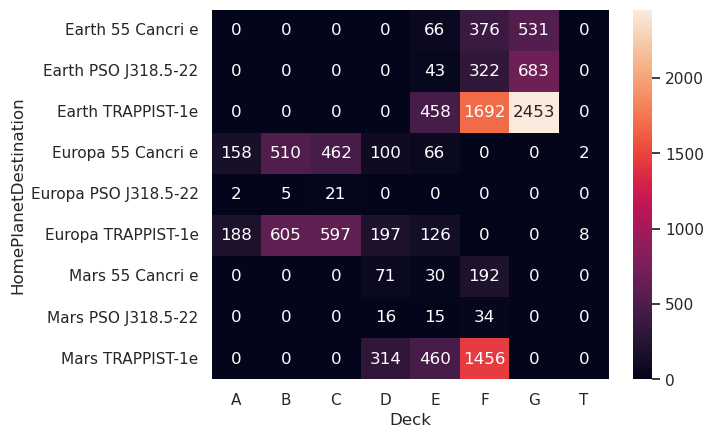

In [23]:
train_test['HomePlanetDestination'] = train_test['HomePlanet'] + ' ' + train_test['Destination']

sns.heatmap(pd.crosstab(train_test['HomePlanetDestination'], train_test['Deck']), annot=True, fmt='g')

plt.show()

There are some Decks that only travelled from one Homeplanet. Based on this we can begin to map the missing HomePlanet values.

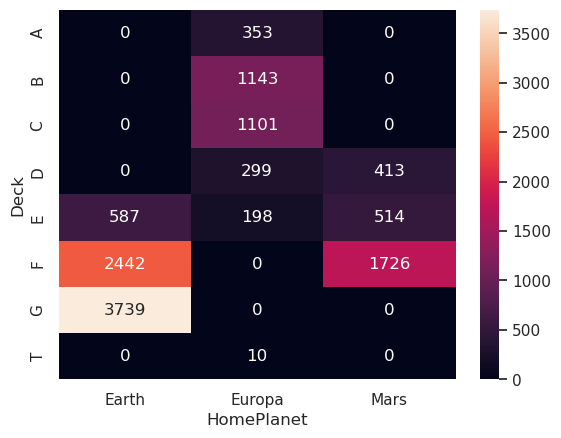

In [24]:
sns.heatmap(pd.crosstab(train_test['Deck'], train_test['HomePlanet']), annot=True, fmt='g')
plt.show()

In [25]:
homeplanet_deck_mapping = {'A': 'Europa'
                      ,'B': 'Europa'
                      ,'C': 'Europa'
                      ,'G': 'Earth'
                      ,'T': 'Europa'
                      }

train_test = impute_from_mapping(train_test, 'HomePlanet', 'Deck', homeplanet_deck_mapping)

The Nan values for HomePlanet were reduced from 288 to 158


We will fill the remaining values with Earth since that is the most common option and there isn't any other obvious ways we can use other fields to impute HomePlanet.

In [26]:
train_test["HomePlanet"] = train_test["HomePlanet"].fillna('Earth')

We will impute Destination with TRAPPIST-1e since it the most common value.

In [27]:
train_test["Destination"] = train_test["Destination"].fillna('TRAPPIST-1e')

Now that we have no NA values for HomePlanet and Destination we can impute Deck based on the combination of the two features as above.

In [28]:
train_test['HomePlanetDestination'] = train_test['HomePlanet'] + ' ' + train_test['Destination']

deck_hpd_ct = pd.crosstab(train_test['HomePlanetDestination'], train_test['Deck'])

deck_hpd_mapping = deck_hpd_ct.idxmax(axis=1).to_dict()

train_test = impute_from_mapping(train_test, 'Deck', 'HomePlanetDestination', deck_hpd_mapping)

train_test.drop('HomePlanetDestination', axis=1, inplace=True)

The Nan values for Deck were reduced from 162 to 0


Looking back to the Num/Age graph we now need to make sure that Side has no na values so we can make out Num linear model predictions.

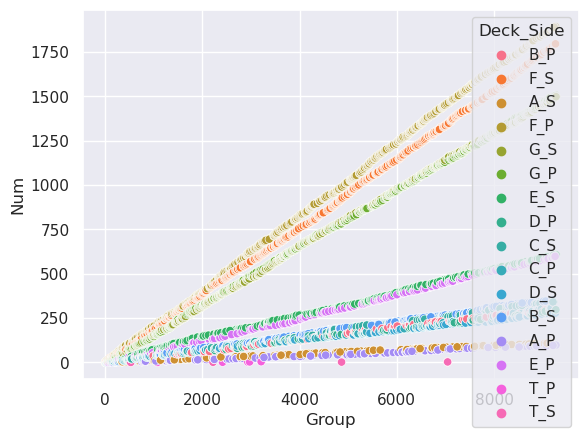

In [29]:
sns.scatterplot(train_test, x='Group', y='Num', hue='Deck_Side')

plt.show()

We can see that all groups are on the same side, so we can infer wide from our group examples.

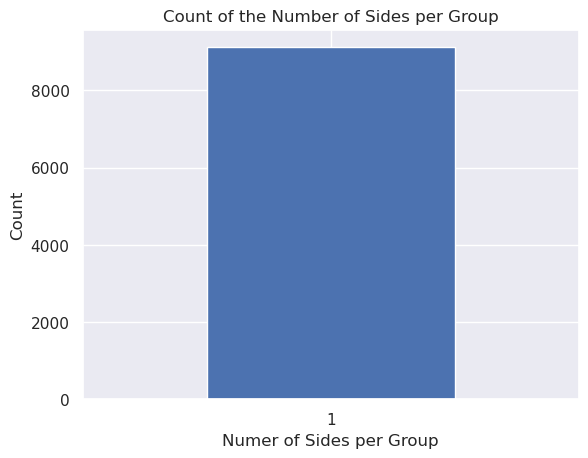

In [30]:
decks_per_side = (pd.crosstab(train_test['Group'], train_test['Side']) > 0).sum(axis=1).value_counts()

decks_per_side.plot(kind='bar')

plt.xlabel('Numer of Sides per Group')
plt.xticks(rotation=0)
plt.ylabel('Count')

plt.title('Count of the Number of Sides per Group')

plt.show()

In [31]:
side_group_ct = pd.crosstab(train_test['Group'], train_test['Side'])

side_group_mapping = side_group_ct.idxmax(axis=1).to_dict()

train_test = impute_from_mapping(train_test, 'Side', 'Group', side_group_mapping)

The Nan values for Side were reduced from 299 to 162


We have imputed as we can, and since S is the slight majority side, we will impute the remaining 162 values with that.

In [32]:
train_test["Side"] = train_test["Side"].fillna('S')

Now that Deck and Side have no na values we will create the linear regression models needed to predict the missing Num values.

In [33]:
def create_linear_models_and_plot():
    
    sns.scatterplot(train_test, x='Group', y='Num', hue='Deck_Side')

    deck_sides = (train_test['Deck_Side']).unique()

    deck_sides_models = {}

    for deck_side in deck_sides:
    
        deck_mask = (train_test['Deck_Side'] == deck_side) & ~(train_test['Num'].isna())
    
        X = train_test.loc[deck_mask,'Group'].values.reshape(-1,1)
        y = train_test.loc[deck_mask,'Num'].values
    
    
        model = LinearRegression()
    
        
        if len(X) > 0:
        
            model.fit(X,y)
    
            deck_sides_models[deck_side] = model
        
            X_example = np.array([[0],[8000]])
            
            y_group = model.predict(X_example)
            
            sns.lineplot(x=X_example.reshape(-1), y=y_group)
            
            #print(f'Build model for deck side: {deck_side})
        
        else:
        
            deck_sides_models[deck_side] = 'NA'
            
    return deck_sides_models
    

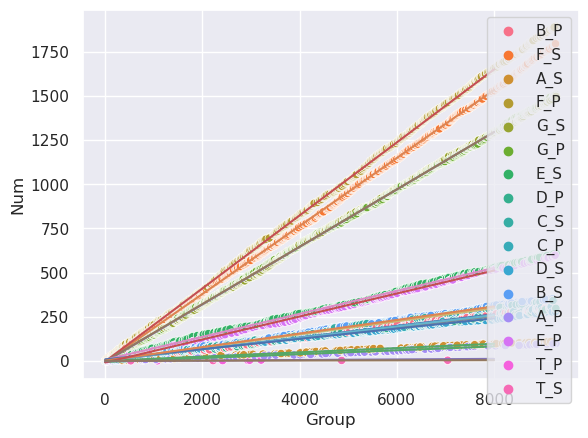

In [34]:
train_test['Deck_Side'] = train_test['Deck'] + '_' + train_test['Side']

deck_sides_models = create_linear_models_and_plot()

In [35]:
def predict_from_linear_models(deck_sides_models):
    
    for deck_sides_model in deck_sides_models.items():
    
        column_na_before = train_test['Num'].isna().sum()
    
        deck_side = deck_sides_model[0]
        model = deck_sides_model[1]
    
        num_na_deck_side_mask = (train_test['Num'].isna()) & (train_test['Deck_Side'] == deck_side)
    
        if (model != 'NA') & (num_na_deck_side_mask.sum() > 0): 
        
            train_test.loc[num_na_deck_side_mask, 'Num'] = model.predict(train_test.loc[num_na_deck_side_mask, 'Group'].values.reshape(-1,1)).astype(int)
        
        
        column_na_after = train_test['Num'].isna().sum()
    
        print(f'The Nan values for Num were reduced from {column_na_before} to {column_na_after}')
        
        # set any negative predictions to group 0
        negative_num_mask = train_test['Num'] < 0
        
        train_test.loc[negative_num_mask, 'Num'] = 0

In [36]:
predict_from_linear_models(deck_sides_models)

train_test.drop('Deck_Side', axis=1, inplace=True)

The Nan values for Num were reduced from 299 to 292
The Nan values for Num were reduced from 292 to 243
The Nan values for Num were reduced from 243 to 242
The Nan values for Num were reduced from 242 to 231
The Nan values for Num were reduced from 231 to 114
The Nan values for Num were reduced from 114 to 89
The Nan values for Num were reduced from 89 to 79
The Nan values for Num were reduced from 79 to 74
The Nan values for Num were reduced from 74 to 62
The Nan values for Num were reduced from 62 to 53
The Nan values for Num were reduced from 53 to 48
The Nan values for Num were reduced from 48 to 7
The Nan values for Num were reduced from 7 to 1
The Nan values for Num were reduced from 1 to 0
The Nan values for Num were reduced from 0 to 0
The Nan values for Num were reduced from 0 to 0


## Binning Num

We will now translate the Num nuemrical feature into distrete bands, as we did for Age.

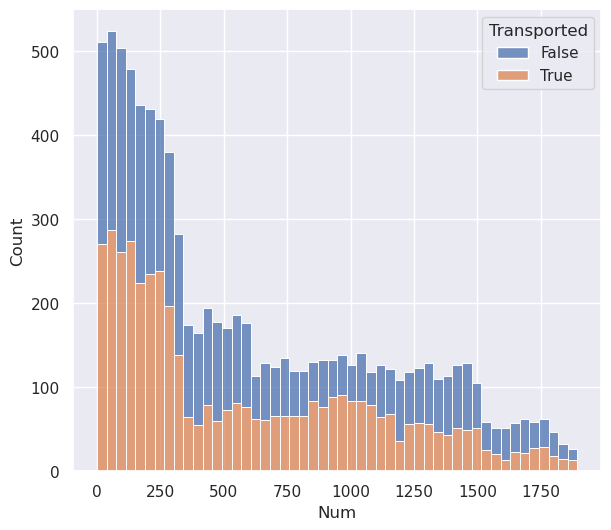

In [37]:
feature_to_target(train_test[0:train_len], ['Num'], figsize=(15,6), bins=50)

In [38]:
bins = np.arange(-1,2001,250)
names = ['0-249', '250-499', '500-749', '750-999', '1000-1249', '1250-1499', '1500-1749', '1750-1999']

train_test['NumBand'] = pd.cut(train_test['Num'], bins, labels=names)

The different bandings for Num show different patterns in the distribution of Transported, so will be a useful feature. We can the drop the Num column, and also the Group column which we only kept to help impute Num.

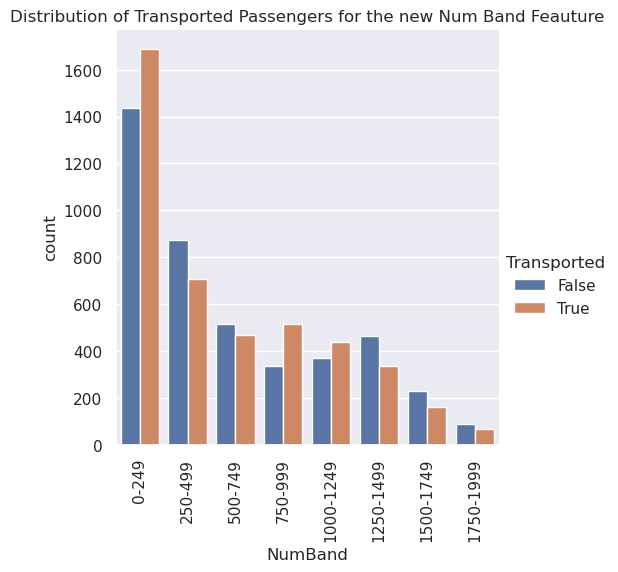

In [39]:
sns.catplot(data=train_test[0:train_len], x="NumBand", kind="count", hue='Transported')

plt.xticks(rotation=90)
plt.title('Distribution of Transported Passengers for the new Num Band Feauture')

plt.show()

train_test.drop('Num', axis=1, inplace=True)
train_test.drop('Group', axis=1, inplace=True)

## Imputing Remaining Features

The remaining columns with na values are CryoSleep and VIP which we will impute with the mode.

In [40]:
na_count = train_test.isna().sum()
na_count[na_count > 0]
print(na_count[na_count > 0])

CryoSleep    310
VIP          296
dtype: int64


In [41]:
train_test["CryoSleep"] = train_test["CryoSleep"].fillna(False)
train_test["VIP"] = train_test["VIP"].fillna(0)

# Get dummies and split into original train & test set

We've imputed all of the missing values so we need to prepare the dataset so that it can be modelled by our Random Forest Model. For this we can't have categorical features, so we will translate them into dummy Boolean features.

In [42]:
train_test = pd.get_dummies(train_test)

X_train = train_test[0:train_len]
X_submission = train_test[train_len:]

In [43]:
y_train = X_train['Transported']
X_train = X_train.drop(['Transported'], axis=1)

X_submission = X_submission.drop(['Transported'], axis=1)

# Use Optuna to find optimal Hyperparamters for a Random Forest Model

Using Optuna we will define the objective function that we are trying to minimise, which is the log loss of our Random Forest model. As part of this we will define the Hyperparameter space that Optuna will be searching through. We have chosen commonly tuned Hyperparameters to trial to see which ones help our model's performance.

First we will train a Random Forest Classifier with the default parameters to give us a benchmark. From that we can see what improvements can be made by using Optuna.


In [44]:
def train_test_model(model, X, y, test_size=0.3, random_state=1):

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=random_state)
    
    model.fit(X_train, y_train)
        
    y_pred = model.predict(X_test)
        
    logloss = log_loss(y_test, y_pred)
    
    return logloss

In [45]:
random_state = 3548

default_model = RandomForestClassifier(random_state=random_state)

default_logloss = train_test_model(default_model, X_train, y_train, 0.3, random_state)

print(f'Using the default Random Forest Parameters we obtain a log loss score of {default_logloss:.2f}')

Using the default Random Forest Parameters we obtain a log loss score of 7.24


We will be performing 3 fold cross validation and computing the mean log loss in order to avoid overfitting our hyperparameters, which can lead to poorer performance on unseen data. The hyperparameters we will be tuning are:
- n_estimators - the number of Decision Trees used in the Random Forest Ensemble
- max_depth - the Maximum depth of the individual Decision Trees
- min_samples_leaf - the minimum number of samples in a leaf node created by a split needed for a split to occur
- min_samples_split - the minimum number of samples in a leaf node needed to split it further
- max_features - The maximum number of features used at each split when finding the optimal splitting feature

Optuna uses a Bayesian optimization algorithm to learn about how the available hyperparameters affect to objective function, in this case the log loss score average across 3 fold cross validation. With each successive trial it learns more information and uses this information to suggest new values for each hyperparameter that it thinks will lead to further improvement.

In [46]:
def objective(trial):
    
    folds = 3
    ## define hyperparatmers
    params = {
            'n_estimators': trial.suggest_int('n_estimators', 1, 1000)
            ,'max_depth': trial.suggest_int('max_depth', 1, 250)
            ,'min_samples_leaf': trial.suggest_int('min_samples_leaf', 2, 25)
            ,'min_samples_split': trial.suggest_int('min_samples_split', 2, 50)
            ,'max_features': trial.suggest_categorical('max_features', choices = ['sqrt', 'log2', None])
    }
    
    # train model
    model = RandomForestClassifier(**params, random_state = np.random.seed(50))
    
    
    kf = KFold(n_splits=folds)
    
    logloss = np.empty(folds)
    
    for i, (train_index, test_index) in enumerate(kf.split(X_train)):
        
        model.fit(X_train.iloc[train_index,:], y_train.iloc[train_index])
        
        y_pred = model.predict(X_train.iloc[test_index,:])
        
        logloss[i] = log_loss(y_train.iloc[test_index], y_pred)
        
    logloss_mean = np.mean(logloss)
    
    return logloss_mean

Let's run 100 trials and see how hyperparameter tuning can help increase the accuracy of our model. We will set the seed for reproducibility.

In [47]:
sampler = TPESampler(seed=5684) 

study = optuna.create_study(direction='minimize',sampler=sampler)

study.optimize(objective, n_trials=100)

[I 2024-04-14 09:34:23,100] A new study created in memory with name: no-name-900e22cf-9038-4994-b0a1-948033956e53
[I 2024-04-14 09:34:29,256] Trial 0 finished with value: 7.493430748682777 and parameters: {'n_estimators': 399, 'max_depth': 105, 'min_samples_leaf': 23, 'min_samples_split': 44, 'max_features': 'sqrt'}. Best is trial 0 with value: 7.493430748682777.
[I 2024-04-14 09:34:35,152] Trial 1 finished with value: 7.239145480537842 and parameters: {'n_estimators': 89, 'max_depth': 150, 'min_samples_leaf': 5, 'min_samples_split': 42, 'max_features': None}. Best is trial 1 with value: 7.239145480537842.
[I 2024-04-14 09:34:46,424] Trial 2 finished with value: 7.847047531989889 and parameters: {'n_estimators': 842, 'max_depth': 216, 'min_samples_leaf': 23, 'min_samples_split': 33, 'max_features': 'log2'}. Best is trial 1 with value: 7.239145480537842.
[I 2024-04-14 09:34:54,754] Trial 3 finished with value: 7.839092596486985 and parameters: {'n_estimators': 622, 'max_depth': 157, 'mi

We can set that as the number of trials increases, Optuna makes steady decreases in the log loss while experimenting with different combinations of hyperparameters. Initially, we see larger decreases in the log loss, but as the number of trials increases, the improvements decrease in size as we converge on one of optimal combinations of hyperparameters.

*Note: Optuna searches for the most optimal combination of hyperparameters in the supplied hyperparameter space, but similar to how ML models can, Optuna can find local minima rather than the global minima so there may be a better combination of hyperparameters available. This method is just much quicker at converging on efficient combinations than more traditional methods like Grid Search.*


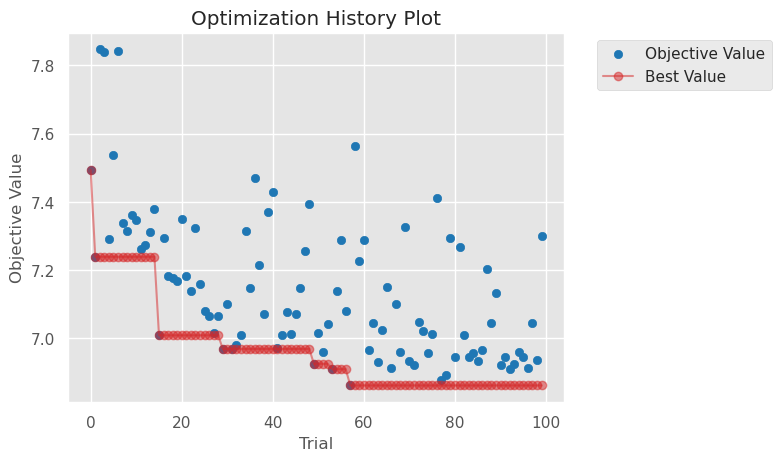

In [48]:
optuna.visualization.matplotlib.plot_optimization_history(study)
plt.show()

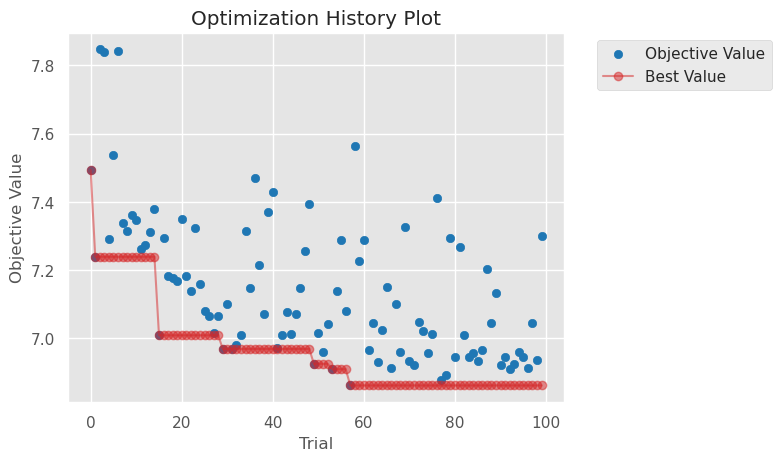

In [49]:
optuna.visualization.matplotlib.plot_optimization_history(study)
plt.show()

With Optuna's plot_slice plot we can see how each hyperparameter performed individually. 

For this study Max Depth converged around the middle of the defined range (at 119), although in the range ~90 to ~190 it performed similarly. Although you may expect deeper trees to perform better, this can 1. lead to overfitting in which case we need a large number of estimators to compensate, and 2. may not even be possible based on the sample size and splitting restrictions set by Min Sample Leaf and Min Sample Split, which may be why it settled at this middle value in our range.

Using the Square Root method was by far the best way to decide on the number of features to look at for each split. Log2 was second with no method (i.e. using all features) performing the worse, which is expected since using all features can result in the model only using the most predominant features and not using the less predominant ones, which can still give the model useful information.

Min Sample Leaf and Min Sample Split both tended towards the lower values, where we allow the trees to keep splitting until we have very few samples left in outer nodes, with Min Sample Leaf showing a strong correlation between it's value and the log loss. This on it's own can cause overfitting of the model, since it begins to learn patterns in very small subsets of the data which can tend not to apply to unseen data, but having a large number of estimators can counteract this since each models overfitting can be "cancelled out" by using a large number of models.

We see that the model found a number of estimators of 767 in the trials we did, although looking at the distribution, the model performed similarly well for a large range of values. In the case of wanting the most optimal model accuracy, then taking this peak value would make sense, but in cases where you are looking to deploy models to production, we may be better off using a lower number of estimators. This is because although we may see a slight decrease in performance, the model training time could be decreased by using fewer estimators, and so may be a better production solution.

*Note: This view doesn't let you view the interactions between hyperparameters since it only focuses on one hyperparameter at a time, so it's not always clear from the graphs which trials were of result of the hyperparameter being plotted, or the other hyperparameters being chosen which you can't see, for example although we see a strong correlation between Min Samples Leaf and the log loss, we see values of MSL the same as the optimal value found with much worse performance. In this case, it is likely on these trials, the other hyperparameters were set to poor performing values. For looking at the overall trend though, it is useful to get a view of the general trend for each of the hyperparameters.*

*Additionally, as mentioned previously, we may see differing results if we re-ran the trial since the optimal set of hyperparameters found could sit in a local optima, so there may be different sets of hyperparameters that vary from ours but produce a similar peak performance.*

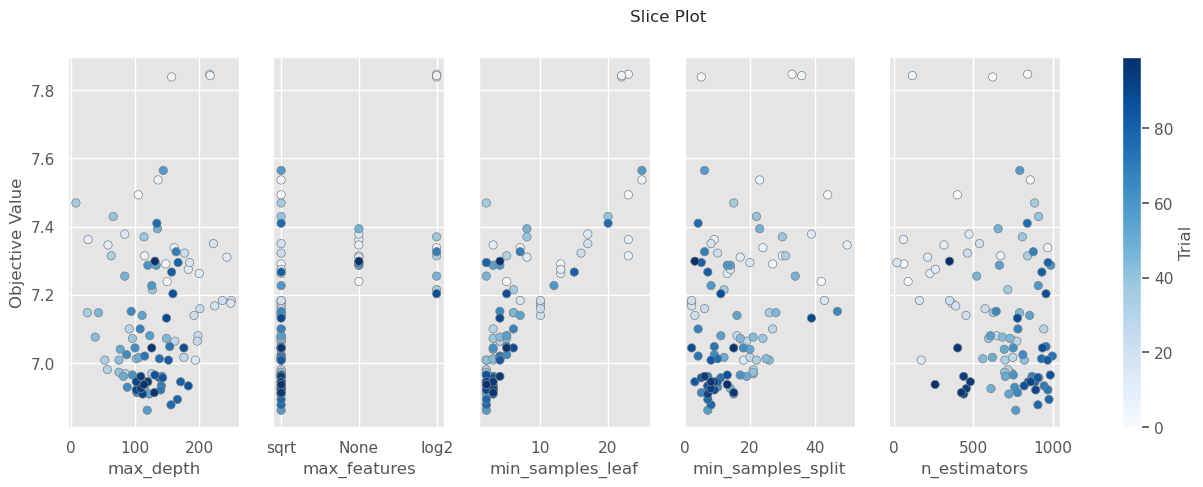

In [50]:
optuna.visualization.matplotlib.plot_slice(study)
plt.show()

We can view the interactions between two hyperparameters more specifically using the plot_contour plot.Below we can see firstly the interactions between Max Depth and Number of Estimators, and how these two hyperparameters affect the model's log loss score. 

We can see that perfomance for low values of both hyperparameters is worse (has a lighter gradient), which is as expected since the model could have less availabiltiy to model all the complexity within the dataset in these cases. For high values of Max Depth, the performance seemed to be largely independant on the Number of Estimators, since we see a light gradient across this side (apart from 2 individual trials which appear to be outliers and whose performance may have been impacted by other hyperparameters).

The optimal combinations sit where Max Depth and Number of Estimators are around the centre of their ranges, but we can see there is a range quite an area of dark blue contours around there where we see good model performance.

[W 2024-04-14 09:59:09,291] Output figures of this Matplotlib-based `plot_contour` function would be different from those of the Plotly-based `plot_contour`.


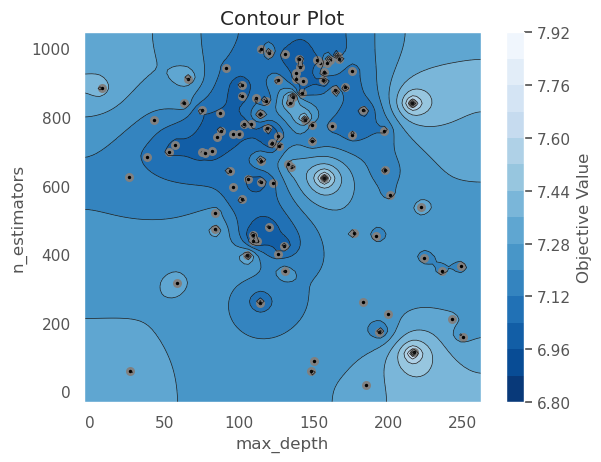

In [51]:
optuna.visualization.matplotlib.plot_contour(study, params=["max_depth", "n_estimators"])
plt.show()

For Min Sample Leaf and Min Sample Split we see, similarly to what we observed in their slice plots, that a combination of low values for both provided the best performance. And trials having high values for both saw poor performance (white contours), whereas a high value of one and a low value of the other saw slight improvement (light blue contours). 

Compared to the above contour plot, it's clear that these two had a much more direct impact on the log loss, so we'd want to make sure we stuck with the lower values in all cases.

[W 2024-04-14 09:59:10,063] Output figures of this Matplotlib-based `plot_contour` function would be different from those of the Plotly-based `plot_contour`.


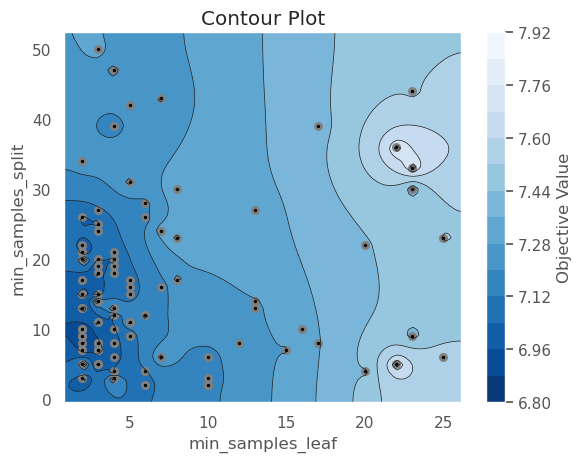

In [52]:
optuna.visualization.matplotlib.plot_contour(study, params=["min_samples_leaf", "min_samples_split"])
plt.show()

Optuna also allows you to see which hyperparameters were most important in improving the objective function.

In our case Min Samples Leaf as by far the most important which is expected since it's slice plot showed the most correlated distribution against the log loss, whereas other plots had a more spread out distribution. From this we can infer that the dataset had a reasonable amount of complexity between features and target, because we required leaf nodes with a small number of individual passengers in order to model the patterns in the dataset.

Max Features was also deemed an important feature since there were many examples of the square root method performing better than the two others.

Max Depth and Min Samples Split were somewhat important, whereas Number of Estimators was deemed unimportant, i.e. Optuna deemed that varying this hyperparameter had little effect on the log loss, and most of the improvement was driven by the other hyperparameters, which can be seen by the high performance across a range of Max Depth values.


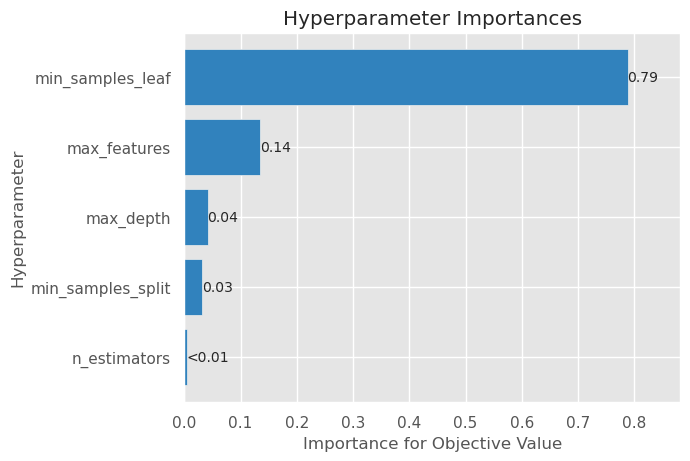

In [53]:
optuna.visualization.matplotlib.plot_param_importances(study)
plt.show()

Now that we have optimised our hyperparameters, we can take the parameters from the most optimal trial and use those to train a model and compare it's results to our default model's results.

In [54]:
best_trial = study.best_trial
params = best_trial.params

In [55]:
optimal_model = RandomForestClassifier(**params)

optimal_logloss = train_test_model(optimal_model, X_train, y_train, 0.3, random_state)

print(f'Using the optimal hyperparemters found by Optuna we obtain a log loss score of {optimal_logloss:.2f}.\n')

improvement = 100 * (default_logloss - optimal_logloss)/default_logloss

print(f'This optimal log loss score of {optimal_logloss:.2f} corresponds to a {improvement:.1f}% improvement compared to the default model\'s log loss of {default_logloss:.2f}.')

Using the optimal hyperparemters found by Optuna we obtain a log loss score of 6.75.

This optimal log loss score of 6.75 corresponds to a 6.8% improvement compared to the default model's log loss of 7.24.


This is the kind of improvement we might expect with Optuna. We would always expect the highest increases in performance will come from proper preprocessing and feature engineering, but we can then often make further improvements to our models using hyperparameter tuning, which Optuna makes much easier to execute and visualise than traditional methods.


# Create Submission

In [56]:
X_submission['Transported'] = optimal_model.predict(X_submission)

In [57]:
# save to csv
X_submission['Transported'].to_csv("submission.csv")